In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import loguniform
from statistics import mean
from scipy import stats
import seaborn as sns
#import scikit_posthocs
import warnings 
import sklearn 
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report,f1_score
from sklearn.impute import SimpleImputer 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import xgboost as xgb

#from scikit_posthocs import posthoc_nemenyi_friedman

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [4]:
df.shape

(918, 12)

In [5]:
a=df.dtypes
a

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [6]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
#from the above there is no datatype object that condradicts with the above description

# we splitted the dataset based on feature type=categorical and numeric. 
allFeatures=df.columns[0:len(df.columns) - 1]
catFeatures=[]
for i in range((len(df.columns)-1)):
    if df.dtypes[i]=='O':
        print(i)
        catFeatures.append(i)
catFeatures.append(5) #fasting bs is categorical 1: if FastingBS > 120 mg/dl, 0: otherwise

catFeatures=df.columns[catFeatures]
print(catFeatures)

numFeatures= [i for i in allFeatures if not(i in catFeatures)]
print(allFeatures)

1
2
6
8
10
Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope',
       'FastingBS'],
      dtype='object')
Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')


In [8]:
df[numFeatures].describe()
#get rid of min resting bp or data points that are insignificant.

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


In [9]:
s=0
c= np.where(df['RestingBP']==0)
print(c[0])
df.iloc[449]

[449]


Age                   55
Sex                    M
ChestPainType        NAP
RestingBP              0
Cholesterol            0
FastingBS              0
RestingECG        Normal
MaxHR                155
ExerciseAngina         N
Oldpeak              1.5
ST_Slope            Flat
HeartDisease           1
Name: 449, dtype: object

In [10]:
df=df.drop(index=449,axis=0) #removed this index because it has resting BP. and Cholestrol zero

In [11]:
df=df.reset_index()
df=df.drop(['index'],axis=1)
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
912,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
913,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
914,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
915,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff00be51f90>,
      dtype=object)

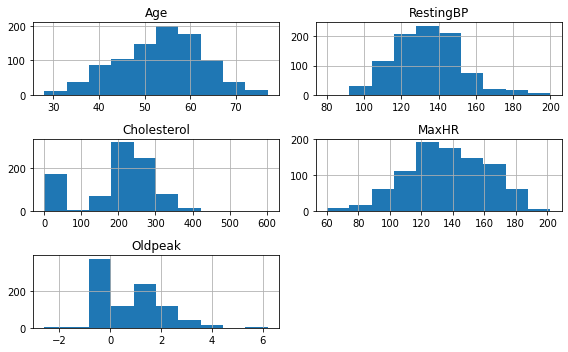

In [12]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.autolayout"] = True
df[numFeatures].hist()


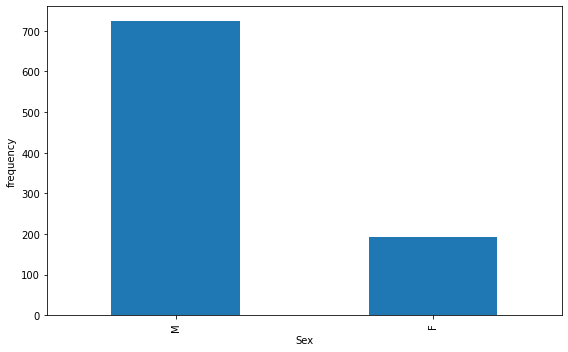

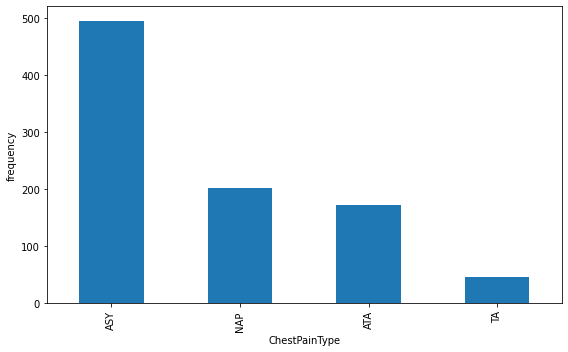

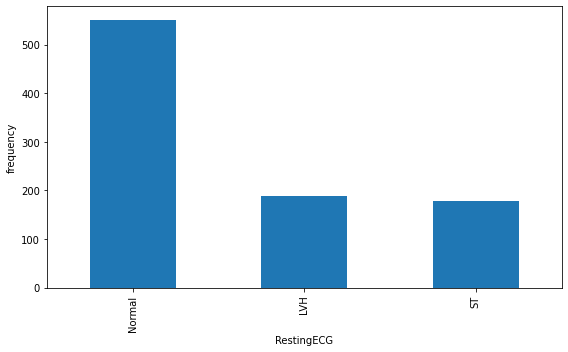

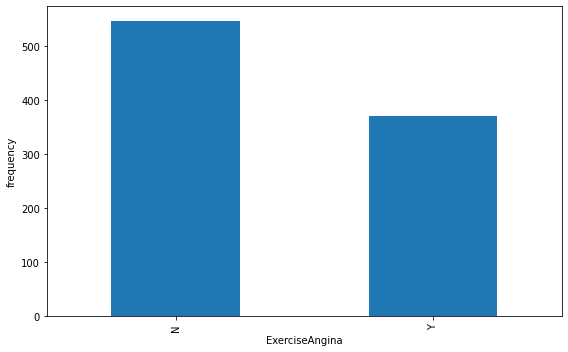

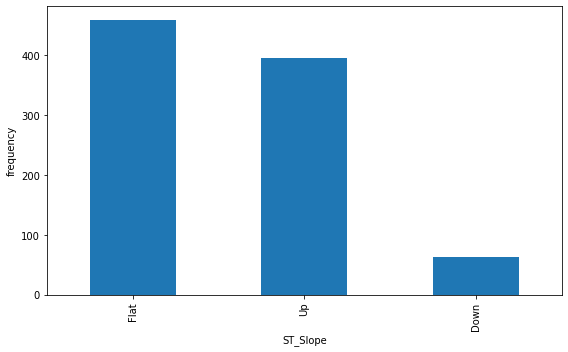

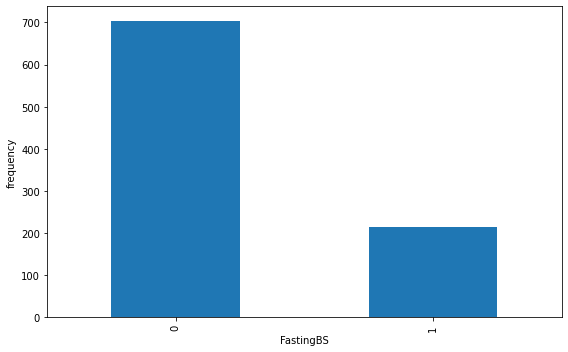

In [13]:
for cat in catFeatures:
    fig, ax = plt.subplots()
    df[cat].value_counts().plot(ax=ax, kind='bar', xlabel=cat, ylabel='frequency')
    plt.show()

In [14]:
for i in catFeatures:
    a=df[i].describe()
    print('\nDescribe for '+ str(i))
    print(a)


Describe for Sex
count     917
unique      2
top         M
freq      724
Name: Sex, dtype: object

Describe for ChestPainType
count     917
unique      4
top       ASY
freq      496
Name: ChestPainType, dtype: object

Describe for RestingECG
count        917
unique         3
top       Normal
freq         551
Name: RestingECG, dtype: object

Describe for ExerciseAngina
count     917
unique      2
top         N
freq      546
Name: ExerciseAngina, dtype: object

Describe for ST_Slope
count      917
unique       3
top       Flat
freq       459
Name: ST_Slope, dtype: object

Describe for FastingBS
count    917.000000
mean       0.233370
std        0.423206
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: FastingBS, dtype: float64


In [15]:
df.isnull().sum() #No null observations

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [16]:
numFeatures.append('HeartDisease')
numFeatures

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']

In [17]:
corr_matrix=df[numFeatures].corr()
print(corr_matrix)

                   Age  RestingBP  ...   Oldpeak  HeartDisease
Age           1.000000   0.263084  ...  0.258563      0.282012
RestingBP     0.263084   1.000000  ...  0.174252      0.117990
Cholesterol  -0.095142   0.089392  ...  0.051390     -0.231479
MaxHR        -0.382280  -0.109693  ... -0.161213     -0.401410
Oldpeak       0.258563   0.174252  ...  1.000000      0.403638
HeartDisease  0.282012   0.117990  ...  0.403638      1.000000

[6 rows x 6 columns]


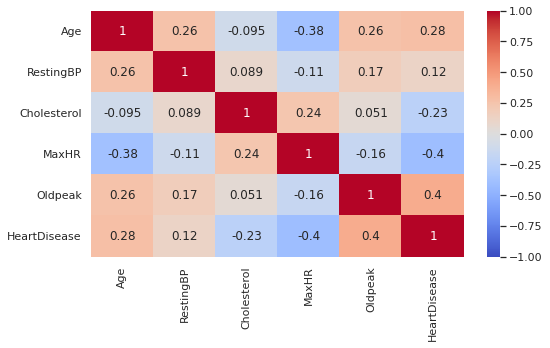

In [18]:
#Visualize Pearson pairwise correlation of features
fig = plt.figure()
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(corr_matrix,cmap='coolwarm', vmin=-1, vmax=1,annot = True)
plt.xticks(rotation=90)
ax.set_xticklabels(df[numFeatures].columns)
ax.set_yticklabels(df[numFeatures].columns)
plt.show()

In [19]:
#dfC is the dataFrame w/ cholesterol
dfC=df
#Remove Cholesterol variable
df = df.drop(labels = "Cholesterol", axis = 1)

In [20]:
allFeatures=df.columns[0:len(df.columns)-1].tolist()

catFeatures=[]
for i in range((len(df.columns)-1)):
    if df.dtypes[i]=='O':
        print(i)
        catFeatures.append(i)
catFeatures.append(4) #fasting bs is categorical 1: if FastingBS > 120 mg/dl, 0: otherwise

catFeatures=df.columns[catFeatures].tolist()
print(catFeatures)

numFeatures= [i for i in allFeatures if not(i in catFeatures)]
print(numFeatures)

1
2
5
7
9
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
['Age', 'RestingBP', 'MaxHR', 'Oldpeak']


In [ ]:
# catFeaturesC = catFeatures
# numFeaturesC = numFeatures.append("Cholesterol")

In [21]:
#HC CLUSTERING
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn import preprocessing

In [23]:
X = df[allFeatures]
y = df["HeartDisease"]

scaler = StandardScaler() #Creates a SKlearn standard Scaler object

    
#STANDARD SCALER
scaler.fit(X[numFeatures]) 
X[numFeatures]=scaler.transform(X[numFeatures])

#Label encoding
le = preprocessing.LabelEncoder()
for feature in catFeatures:
    X[feature] = le.fit_transform(X[feature])

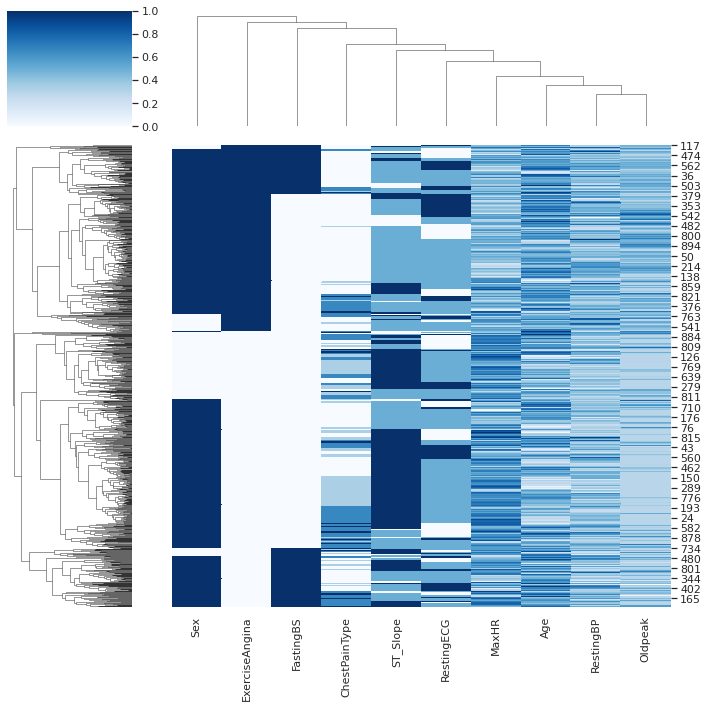

In [24]:
# Heat map with scaling and label encoder
g = sns.clustermap(X, method = "average", metric="euclidean", cmap="Blues", standard_scale = 1)

In [25]:
X = df[allFeatures]
y = df["HeartDisease"]

scaler = StandardScaler() #Creates a SKlearn standard Scaler object

    
#STANDARD SCALER
scaler.fit(X[numFeatures]) 
X[numFeatures]=scaler.transform(X[numFeatures])

#Get dummies
X = pd.get_dummies(X, columns=catFeatures) 


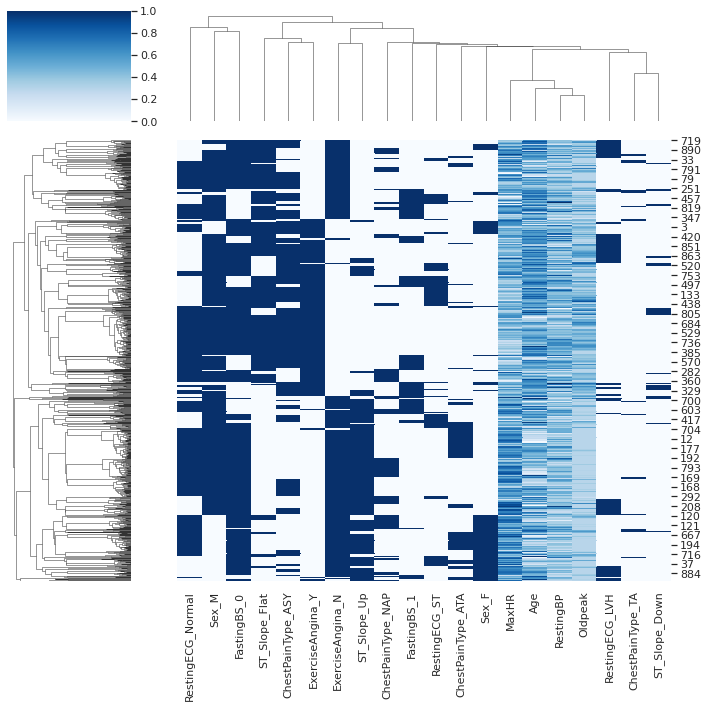

In [26]:
# Heat map with scaling and get dummies
g = sns.clustermap(X, method = "average", metric="euclidean", cmap="Blues", standard_scale = 1)

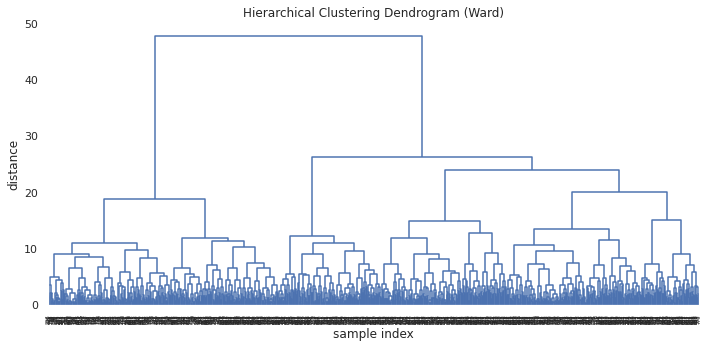

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(X, 'ward')
figure = plt.figure(figsize=(10, 5))
dendrogram(
    linkage_matrix,
    color_threshold=0,
)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.tight_layout()
plt.show()

In [28]:
df[allFeatures]

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,0,Normal,172,N,0.0,Up
1,49,F,NAP,160,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130,0,ST,98,N,0.0,Up
3,48,F,ASY,138,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,0,Normal,122,N,0.0,Up
...,...,...,...,...,...,...,...,...,...,...
912,45,M,TA,110,0,Normal,132,N,1.2,Flat
913,68,M,ASY,144,1,Normal,141,N,3.4,Flat
914,57,M,ASY,130,0,Normal,115,Y,1.2,Flat
915,57,F,ATA,130,0,LVH,174,N,0.0,Flat


In [29]:
X_train, X_test, y_train, y_test = train_test_split(df[allFeatures], df["HeartDisease"], test_size = 0.2, random_state=42, stratify=df["HeartDisease"])


In [30]:
train = pd.concat([X_train, y_train], axis=1)
train = train.reset_index(drop=True)
train

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,49,M,ASY,128,0,Normal,96,Y,0.0,Flat,1
1,68,M,NAP,134,1,Normal,151,Y,0.0,Up,0
2,59,M,NAP,126,1,Normal,134,N,2.2,Flat,1
3,67,M,ASY,125,1,Normal,163,N,0.2,Flat,1
4,52,M,ASY,160,0,Normal,94,Y,2.5,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...
728,51,M,NAP,135,0,Normal,150,N,2.0,Flat,1
729,46,M,NAP,120,0,Normal,150,N,0.0,Up,0
730,59,M,NAP,131,0,Normal,128,Y,2.0,Down,1
731,61,M,ASY,125,0,ST,115,Y,0.0,Up,0


In [31]:
np.random.seed(1) #Set a random seed for reproducibility
inBags = [] 
outBags = []

for i in range(2): #Loop through 50 times to create 50 InBags/OutBags
    
    curInBag = sklearn.utils.resample(train, replace=True) #Creates a boot strap inBag the length of boston with replacement
    
    outBagRows = [] #to hold all of the rows not represented in the inBag
    for i in range(len(train)): 
        if i not in np.unique(list(curInBag.index)):  #Check to see if the row is not represented in the current in bag
            
            outBagRows.append(train.loc[i].to_frame().T) # When I select a row not in the in bag, it is a series
                                                           # I Use the .to_frame to convert the series to a DataFrame
                                                           # The data Frame is oriented the wrong way so the .T transposes it
    
    curOutBag = pd.concat(outBagRows) #This concatenates all of the out bag rows into one DF

    #This if statment checks to see if every row of boston is represnted between the cur inbag and the cur outbag
    if len(np.unique(list(curInBag.index))) + len(np.unique(list(curOutBag.index))) != len(train):
        print("ERROR! ALl of the unique values should be represented")

    #Add the inbag/outBag to their respective lists
    inBags.append(curInBag)
    outBags.append(curOutBag)

In [32]:
scaler = StandardScaler() #Creates a SKlearn standard Scaler object

for i in range(len(inBags)): #Loop through each of the inBags
    
    #STANDARD SCALER
    scaler.fit(inBags[i][numFeatures]) #Transforms inBags
    inBags[i][numFeatures]=scaler.transform(inBags[i][numFeatures])

    scaler.fit(outBags[i][numFeatures]) #Transforms outBags
    outBags[i][numFeatures]=scaler.transform(outBags[i][numFeatures])
    
    #ENCODE CATEGORICAL VARIABLES
   
    inBags[i] = pd.get_dummies(inBags[i], columns=catFeatures)  #Transform inBags
    outBags[i] = pd.get_dummies(outBags[i], columns=catFeatures)  #Transform outBags
    


In [33]:
xFeatures = inBags[0].columns.tolist()
xFeatures.remove('HeartDisease')
yFeatures = ['HeartDisease']

In [34]:
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

model_rf=RandomForestClassifier(random_state=1)
rf_pipeline = Pipeline([ 
    ('model_rf',model_rf)
])
rf_param = {
               'model_rf__bootstrap': [True, False],
               'model_rf__max_depth': [2, 3, 5, 7, 9],
               'model_rf__max_features': [10],
               'model_rf__n_estimators': [10, 100, 500]} 

rf_random_f1 = RandomizedSearchCV(rf_pipeline, rf_param, cv=cv_inner, scoring='f1')
rf_random_auc = RandomizedSearchCV(rf_pipeline, rf_param, cv=cv_inner, scoring='roc_auc')

In [58]:
rfModels_f1 = []
rfModels_auc = []

rfScores_f1 = []
rfScores_auc = []

for i in range(len(inBags)):
    print(i)
    model_f1 = rf_random_f1.fit(inBags[i][xFeatures], np.asarray(inBags[i][yFeatures].squeeze().tolist()))
    rfModels_f1.append(model_f1)
    
    model_auc = rf_random_auc.fit(inBags[i][xFeatures], np.asarray(inBags[i][yFeatures].squeeze().tolist()))
    rfModels_auc.append(model_auc)
    
    curScore_f1 = f1_score(outBags[i][yFeatures].squeeze().tolist(), model_f1.predict(outBags[i][xFeatures]))
    rfScores_f1.append(curScore_f1)
    
    curScore_auc = roc_auc_score(outBags[i][yFeatures].squeeze().tolist(), model_auc.predict(outBags[i][xFeatures]))
    rfScores_auc.append(curScore_auc)

0
1


In [36]:
print(rfScores_f1)
print(rfScores_auc)

[0.8789808917197451, 0.840677966101695]
[0.849210480652438, 0.8642774748322148]


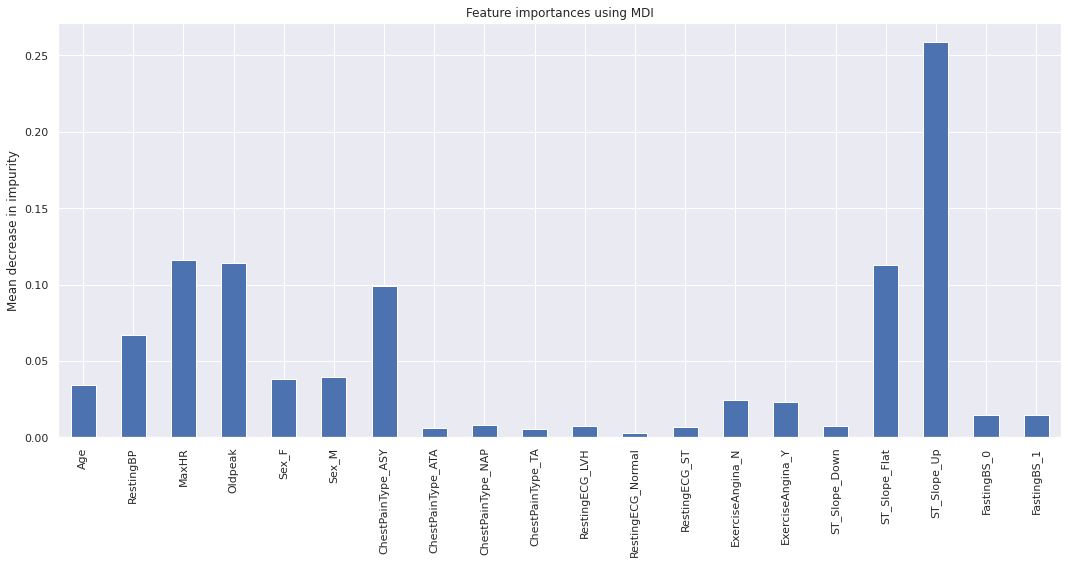

In [88]:
topScore = max(rfScores_auc)
topModel = rfModels_auc[0]
for i in range(len(rfScores_auc)):
    if rfScores_auc[i] == topScore:
        topModel = rfModels_auc[i]
bestModel_RF = topModel.best_estimator_.named_steps["model_rf"]

importances = bestModel_RF.feature_importances_
forest_importances = pd.Series(importances, index=xFeatures)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [38]:
model_xgb = xgb.XGBClassifier(random_state=1,objective='binary:logistic',eval_metric='logloss',use_label_encoder=False)
xgb_pipeline = Pipeline([
    ('model_xgb', model_xgb)
])

xgb_param= {
    'model_xgb__max_depth': [2, 3, 5,7,9],
    'model_xgb__n_estimators': [10, 100, 500]}
xgb_random_f1 = RandomizedSearchCV(xgb_pipeline, xgb_param, cv=cv_inner, scoring='f1')
xgb_random_auc = RandomizedSearchCV(xgb_pipeline, xgb_param, cv=cv_inner, scoring='roc_auc')


In [81]:
xgbModels_f1 = []
xgbScores_f1 = []

xgbModels_auc = []
xgbScores_auc = []

#For colab add this code
for i in range(len(inBags)):
  outBags[i]["Age"] = outBags[i]["Age"].astype(float)
  outBags[i]["RestingBP"] = outBags[i]["RestingBP"].astype(float)
  outBags[i]["MaxHR"] = outBags[i]["MaxHR"].astype(float)
  outBags[i]["Oldpeak"] = outBags[i]["Oldpeak"].astype(float)

for i in range(len(inBags)):
    print(i)
    model_f1 = xgb_random_f1.fit(inBags[i][xFeatures], np.asarray(inBags[i][yFeatures].squeeze().tolist()))
    xgbModels_f1.append(model_f1)
    print("Model 1")
    model_auc = xgb_random_auc.fit(inBags[i][xFeatures], np.asarray(inBags[i][yFeatures].squeeze().tolist()))
    xgbModels_auc.append(model_auc)
    print("Model 2")
    curScore_f1 = f1_score(outBags[i][yFeatures].squeeze().tolist(), model_f1.predict(outBags[i][xFeatures]))
    xgbScores_f1.append(curScore_f1)
    print("Score 1")
    curScore_auc = roc_auc_score(outBags[i][yFeatures].squeeze().tolist(), model_auc.predict(outBags[i][xFeatures]))
    xgbScores_auc.append(curScore_auc)
    print("Score 2")

0
Model 1
Model 2
Score 1
Score 2
1
Model 1
Model 2
Score 1
Score 2


In [82]:
print(xgbScores_f1)
print(xgbScores_auc)

[0.8580441640378549, 0.8646864686468647]
[0.8217074440395628, 0.8497535654362416]


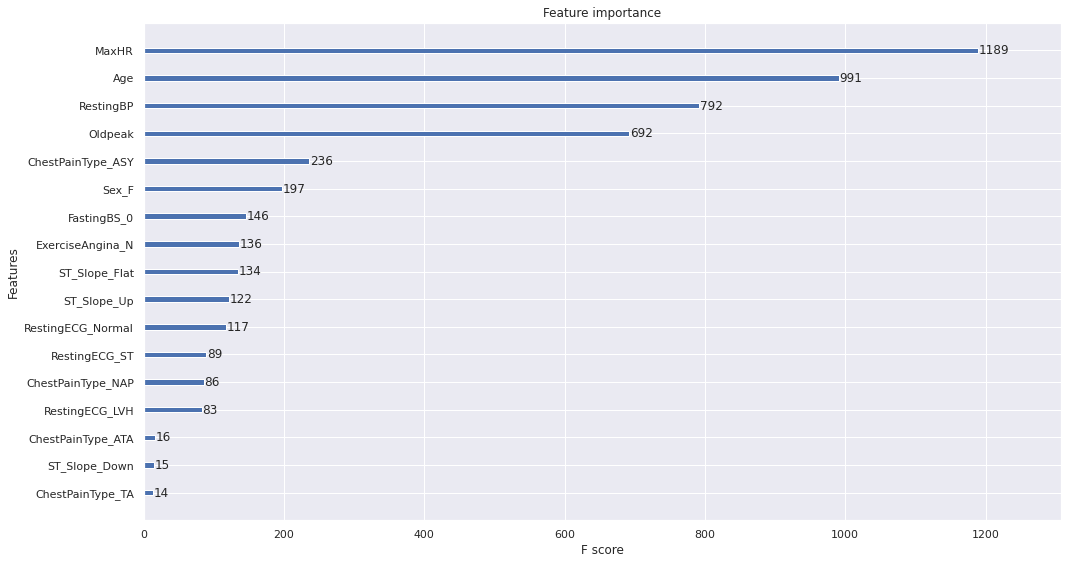

In [85]:
from xgboost import plot_importance 

topScore = max(xgbScores_auc)
topModel = xgbModels_auc[0]
for i in range(len(xgbModels_auc)):
    if xgbScores_auc[i] == topScore:
        topModel = xgbModels_auc[i]

bestModel_XGB = topModel.best_estimator_.named_steps["model_xgb"]

plot_importance(bestModel_XGB)

In [72]:
from sklearn import svm


model_svm=svm.SVC()
svm_pipeline = Pipeline([ 
    ('model_svm',model_svm)
])
svm_param = {
               'model_svm__kernel': ['linear'],
               'model_svm__gamma': ['scale', 'auto'],
               'model_svm__C': [.1, .5, 1, 1.5, 2]}

svm_random_f1 = RandomizedSearchCV(svm_pipeline, svm_param, cv=cv_inner, scoring='f1', random_state=42)
svm_random_auc = RandomizedSearchCV(svm_pipeline, svm_param, cv=cv_inner, scoring='roc_auc', random_state=42)

In [73]:
svmModels_f1 = []
svmScores_f1 = []

svmModels_auc = []
svmScores_auc = []

for i in range(len(inBags)):
    print(i)
    model_f1 = svm_random_f1.fit(inBags[i][xFeatures], np.asarray(inBags[i][yFeatures].squeeze().tolist()))
    svmModels_f1.append(model_f1)

    model_auc = svm_random_auc.fit(inBags[i][xFeatures], np.asarray(inBags[i][yFeatures].squeeze().tolist()))
    svmModels_auc.append(model_auc)

    curScore_f1 = f1_score(outBags[i][yFeatures].squeeze().tolist(), model.predict(outBags[i][xFeatures]))
    svmScores_f1.append(curScore_f1)

    curScore_auc = roc_auc_score(outBags[i][yFeatures].squeeze().tolist(), model.predict(outBags[i][xFeatures]))
    svmScores_auc.append(curScore_auc)

0
1


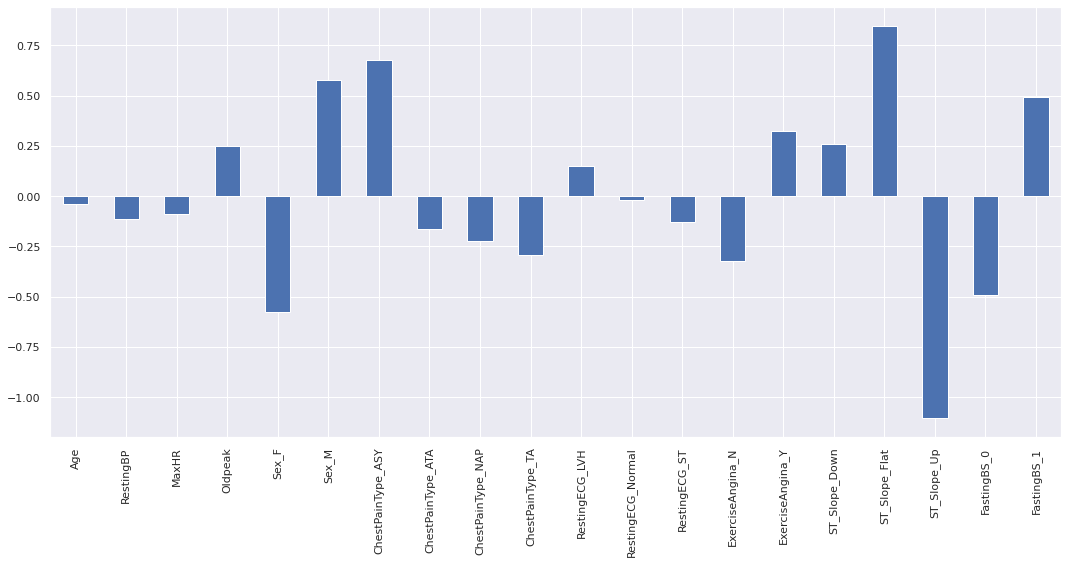

In [74]:
topScore = max(svmScores_auc)
topModel = svmModels_auc[0]
for i in range(len(svmScores_auc)):
    if svmScores_auc[i] == topScore:
        topModel = svmModels_auc[i]
        
bestModel_SVM = topModel.best_estimator_.named_steps["model_svm"]

importances = bestModel_SVM.coef_
#permutation importance

forest_importances = pd.Series(importances[0], index=xFeatures)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
fig.tight_layout()

In [76]:
#Friedman
stats.friedmanchisquare(svmScores_auc,xgbScores_auc,rfScores_auc) #Gets the Friedman statistic

FriedmanchisquareResult(statistic=3.0, pvalue=0.22313016014842982)

In [78]:
#Drop index for test dfs
X_test = X_test.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

In [79]:
scaler = StandardScaler() #Creates a SKlearn standard Scaler object
scaler.fit(X_test[numFeatures])
X_test[numFeatures]=scaler.transform(X_test[numFeatures])
X_test = pd.get_dummies(X_test, columns=catFeatures)  

In [89]:
yhat=bestModel_RF.predict(X_test)
aucscore=roc_auc_score(yhat,y_test)
print(aucscore)

0.8350071736011478


In [90]:
!pip install shap
import shap

shap.initjs()
explainer = shap.KernelExplainer(bestModel_RF.predict_proba,inBags[0][xFeatures])
shap_values = explainer.shap_values(X_test.iloc[10,:])
#SHAP values for class 0 outcomes
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[10,:], feature_names = X_test.columns)

     |████████████████████████████████| 564 kB 5.1 MB/s 


Using 733 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KeyboardInterrupt: ignored

In [ ]:
#SHAP values for class 1 outcomes
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[10,:], feature_names = X_test.columns)